Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Vinay Maruri"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Part 2: EDA, Visualization, Feature Engineering

In this part, we will conduct EDA on the NYC Taxi dataset that we cleaned and train/validation split in part 1. We will also guide you through the engineering of some features that hopefully will help our model to accurately understand the data.


# Imports

Let us start by loading the Python libraries and custom tools we will use in this part.  

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

## Loading & Formatting data

The following code loads the data into a pandas DataFrame.

In [3]:
# Run this cell to load the data. 
data_file = Path("data/part1", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")

In [4]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,40.688210,1,41.5,1.0,0.5,6.00,0.0,0.3,49.30,3644.0
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,40.729271,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,537.0
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,40.758469,1,5.0,1.0,0.5,1.00,0.0,0.3,7.80,344.0
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,40.661118,1,25.5,0.5,0.5,2.68,0.0,0.3,29.48,1959.0
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,40.760792,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,807.0


## 1: Data Overview 

As a reminder, the raw taxi data contains the following columns:
- `recordID`: primary key of this database
- `VendorID`: a code indicating the provider associated with the trip record
- `passenger_count`: the number of passengers in the vehicle (driver entered value)
- `trip_distance`: trip distance
- `tpep_dropoff_datetime`: date and time when the meter was engaged
- `tpep_pickup_datetime`: date and time when the meter was disengaged
- `pickup_longitude`: the longitude where the meter was engaged
- `pickup_latitude`: the latitude where the meter was engaged
- `dropoff_longitude`: the longitude where the meter was disengaged
- `dropoff_latitude`: the latitude where the meter was disengaged
- `duration`: duration of the trip in seconds
- `payment_type`: the payment type
- `fare_amount`: the time-and-distance fare calculated by the meter
- `extra`: miscellaneous extras and surcharges
- `mta_tax`: MTA tax that is automatically triggered based on the metered rate in use	
- `tip_amount`: the	amount of credit card tips, cash tips are not included
- `tolls_amount`: amount paid for tolls
- `improvement_surcharge`: fixed fee
- `total_amount`: total amount paid by passengers, cash tips are not included

Let us take a closer look at the target `duration` variable. In the cell below, we plot its distribution using `sns.distplot`. This should give us an idea about whether we have some outliers in our data.

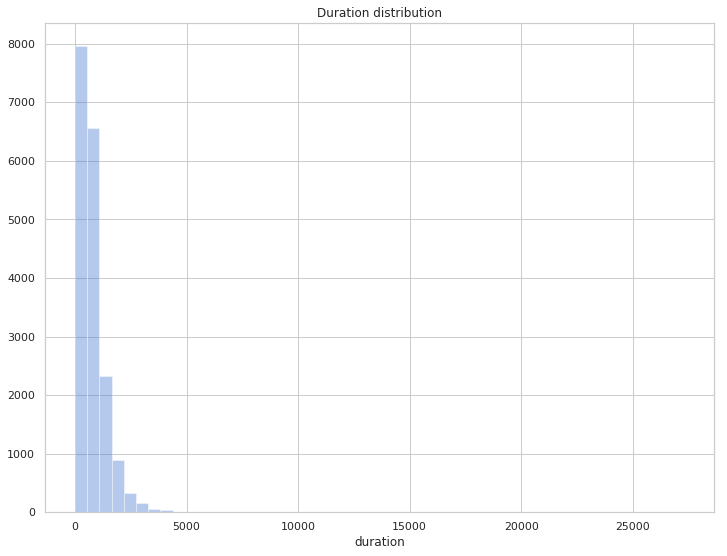

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the distribution of duration using sns.distplot
# You can fill `ax=ax` to sns.distplot to plot in the ax object created above

sns.distplot(train_df['duration'], ax=ax, kde=False)

plt.title('Duration distribution');

As expected for a positive valued variable, we observe a skewed distribution. Note that we seem to have a handful of very long trips within our data. Use an appropriate data transformation to squeeze this highly-skewed distribution. Plot a `sns.distplot` of the transformed duration data for `train_df`.

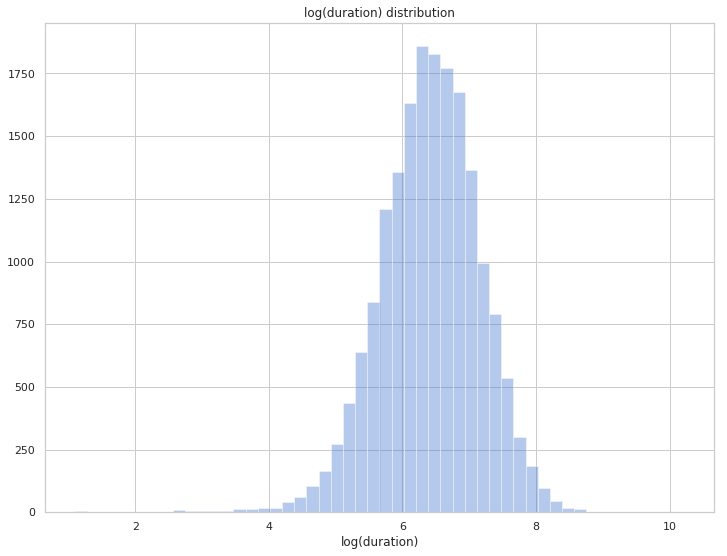

In [6]:
fig, ax = plt.subplots(figsize=(12, 9))

# Use a log transformation to squeeze the distribution
# You can add + 1 to all values before taking the log to handle possible 0 values for distribution

sns.distplot(np.log(train_df['duration'] + 1),
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(duration) distribution');

After transforming our data, we should immediately observe that we are dealing with what seems to be log-normal distribution for the target variable `duration`. We can see the behavior of shorter rides better, whereas before they were lumped in a bar near 0. This is a nice result, since it can facilitate modeling later. 

**Note:** Keep in mind that we want to avoid peeking at our validation data because it may introduce bias. Therefore, we will be focusing on analyzing the training data for the remainder of this notebook.

## 2: Date Analysis

In order to understand the general pattern/trends of our taxi ride data, we will plot the number of taxi rides requested over time. Please run the following cell.

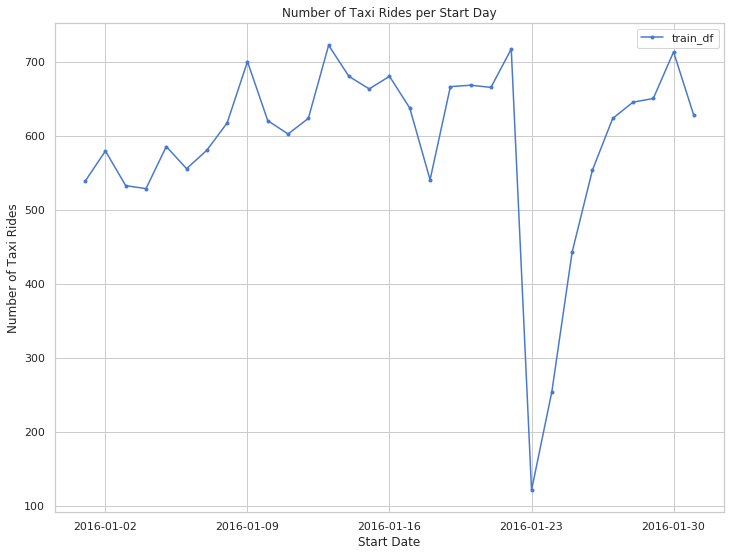

In [7]:
plt.figure(figsize=(12, 9))

# Make a temporary copy of our datasets
tmp_train = train_df.copy()
tmp_train['date'] = tmp_train['tpep_pickup_datetime'].dt.date
tmp_train = tmp_train.groupby('date').count()['pickup_longitude']

# Plot the temporal overlap
plt.plot(tmp_train, '.-', label='train_df')

plt.title('Number of Taxi Rides per Start Day')
plt.xlabel("Start Date")
plt.legend()
plt.ylabel('Number of Taxi Rides');

In [8]:
tmp_train

date
2016-01-01    539
2016-01-02    580
2016-01-03    533
2016-01-04    529
2016-01-05    586
2016-01-06    556
2016-01-07    581
2016-01-08    618
2016-01-09    701
2016-01-10    621
2016-01-11    603
2016-01-12    624
2016-01-13    723
2016-01-14    681
2016-01-15    664
2016-01-16    681
2016-01-17    638
2016-01-18    541
2016-01-19    667
2016-01-20    669
2016-01-21    666
2016-01-22    718
2016-01-23    121
2016-01-24    254
2016-01-25    443
2016-01-26    554
2016-01-27    624
2016-01-28    646
2016-01-29    651
2016-01-30    714
2016-01-31    628
Name: pickup_longitude, dtype: int64

### Question 2a
Taking a closer look at the plot above, we notice a drastic drop in taxi rides towards the end of Janurary.
What is the date corresponding to the lowest number of taxi rides? Enter your answer as a string in the format MM-DD-YYYY.

In [9]:
lowest_rides_date = "01-23-2016"


print(lowest_rides_date)

01-23-2016


In [10]:
# Hidden test!

### Question 2b
What event could have caused this drop in taxi rides? Feel free to use Google.

In [11]:
q2b_answer = r"""

There was a very large blizzard that struck the East Coast of the United States from January 22nd to January 24th, 2016. The strongest day of the storm was on the 23rd, which corresponds with the heaviest day of snowfall during this blizzard event and with the lowest taxi ridership in January 2016. New York City was blanketed with over 2 feet of snow and most roads in the city were impassable due to heavy snow and ice. Furthermore, New York Governor Andrew Cuomo and New York City Mayor Bill de Blasio jointly issued a travel ban for part of January 23rd to keep city roads clear when the storm was at its most intense. The snowstorm and travel ban on January 23rd contributed to the drop in taxi rides in New York City towards the end of January. 

Sources: 
1. https://en.wikipedia.org/wiki/January_2016_United_States_blizzard
2. https://www.nytimes.com/2016/01/26/nyregion/praise-for-de-blasio-and-cuomo-but-complaints-in-queens-after-blizzard.html

"""



print(q2b_answer)



There was a very large blizzard that struck the East Coast of the United States from January 22nd to January 24th, 2016. The strongest day of the storm was on the 23rd, which corresponds with the heaviest day of snowfall during this blizzard event and with the lowest taxi ridership in January 2016. New York City was blanketed with over 2 feet of snow and most roads in the city were impassable due to heavy snow and ice. Furthermore, New York Governor Andrew Cuomo and New York City Mayor Bill de Blasio jointly issued a travel ban for part of January 23rd to keep city roads clear when the storm was at its most intense. The snowstorm and travel ban on January 23rd contributed to the drop in taxi rides in New York City towards the end of January. 

Sources: 
1. https://en.wikipedia.org/wiki/January_2016_United_States_blizzard
2. https://www.nytimes.com/2016/01/26/nyregion/praise-for-de-blasio-and-cuomo-but-complaints-in-queens-after-blizzard.html




## 3. Spatial/Locational Analysis

We are curious about the distribution of taxi pickup/dropoff coordinates. We also may be interested in observing whether this distribution changes as we condition of longer/shorter taxi rides. In the cells below, we will categorize our data into long and short rides based on duration. Then we will plot the latitude and longitude coordinates of rides conditioned on these categories.

First you may want to familiarize yourself with a [map of Manhattan](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

Here we split `train_df` into two data frames, one called `short_rides` and one called `long_rides`. `short_rides` should contain all rides less than or equal to 15 minutes and `long_rides` should contain rides more than 15 minutes. 

**Note:** We chose 15 minutes because the mean duration of a ride is roughly 700 seconds ~ 12 minutes. We then round up to the nearest nice multiple of 5. Note that you should adjust how you determine short/long rides and outliers when feature engineering.

In [12]:
short_rides = train_df[train_df["duration"] <= 900] # rides less than or equal to 15 mins
long_rides = train_df[train_df["duration"] > 900] # rides more than 15 minutes

In [13]:
assert len(short_rides) == 12830
assert len(long_rides) == 5524

Below we generate 4 scatter plots. The scatter plots are ordered as follows:

* ax1: plot the __start__ location of short duration rides
* ax2: plot the __start__ location of long duration rides
* ax3: plot the __end__ location of short duration rides
* ax4: plot the __end__ location of long duration rides

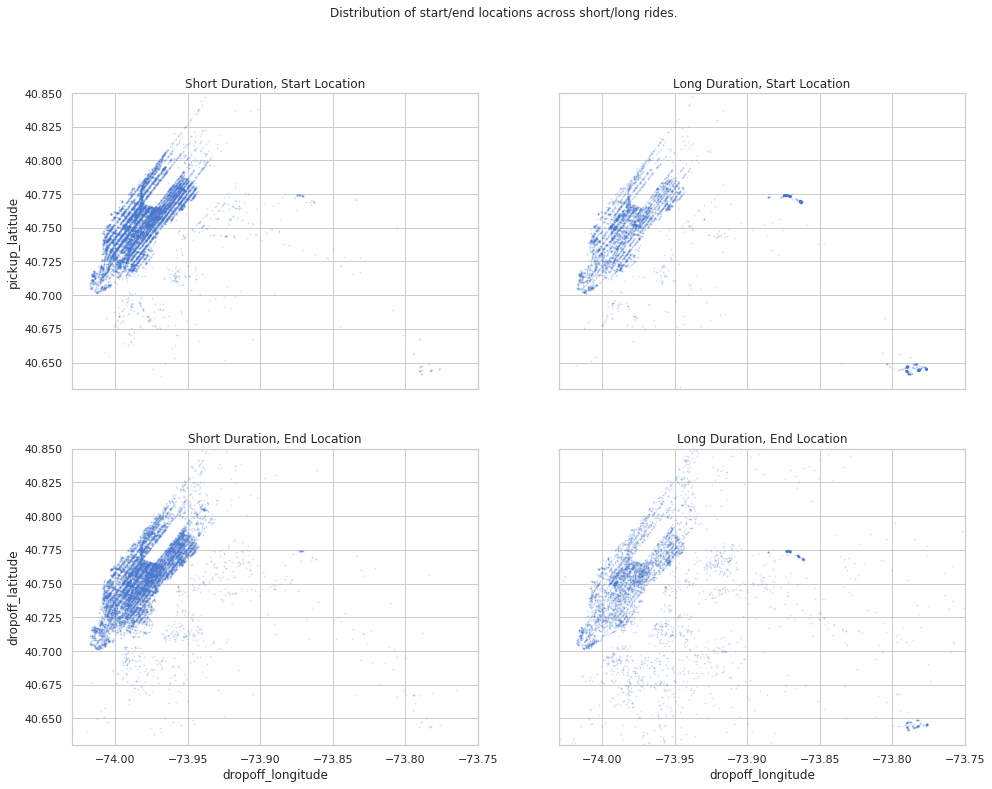

In [14]:
# Set random seed of reproducibility
random.seed(42)

# City boundaries
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Define figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(16, 12), sharex=True, sharey=True)
alpha = 0.15 # make sure to include these as an argument
s = 1 # make sure to include this as an argument

short_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                     ax = ax1, alpha = alpha, s = s, title='Short Duration, Start Location')
long_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                    ax = ax2, alpha = alpha, s = s, title='Long Duration, Start Location')
short_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                     ax = ax3, alpha = alpha, s = s , title='Short Duration, End Location')
long_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                    ax = ax4, alpha = alpha, s = s, title='Long Duration, End Location')


fig.suptitle('Distribution of start/end locations across short/long rides.')


plt.ylim(city_lat_border)
plt.xlim(city_long_border);

### Question 3a

What do the plots above look like? 

In particular:
- Find what the following circled regions correspond to:
<img src="figs/nyc_locations.png" width="50%"></img>

**Hint: Here is a [page](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) that may be useful.**

In [15]:
q3a_answer = r"""
The above plots look like sketches of Manhattan on the short duration plots, and of Manhattan, Brooklyn, and Queens on the long duration plots. This is because the short duration plots are heavily colored blue in areas of Manhattan (with the exception of Central Park), and the long duration plots have heavy plotting in Manhattan, and more lightly plotted areas in Brooklyn and Queens. 

On the plot right above, below question 3a, The smallest circle (on the right) corresponds to the area around New York's LaGuardia Airport. 
The bigger circle corresponds to areas in Manhattan (the more heavily shaded areas) and areas immediately across the East River in Queens (Astoria, Long Island City) and in Brooklyn (Greenpoint, Williamsburg). It also crosses over the Hudson and East Rivers. 
The area in the rectangle corresponds to areas around Central Park, including the Manhattan neighborhoods of Lenox Hill, the Upper East Side, Harlem, the Upper West Side, and areas in Midtown.  

"""


print(q3a_answer)


The above plots look like sketches of Manhattan on the short duration plots, and of Manhattan, Brooklyn, and Queens on the long duration plots. This is because the short duration plots are heavily colored blue in areas of Manhattan (with the exception of Central Park), and the long duration plots have heavy plotting in Manhattan, and more lightly plotted areas in Brooklyn and Queens. 

On the plot right above, below question 3a, The smallest circle (on the right) corresponds to the area around New York's LaGuardia Airport. 
The bigger circle corresponds to areas in Manhattan (the more heavily shaded areas) and areas immediately across the East River in Queens (Astoria, Long Island City) and in Brooklyn (Greenpoint, Williamsburg). It also crosses over the Hudson and East Rivers. 
The area in the rectangle corresponds to areas around Central Park, including the Manhattan neighborhoods of Lenox Hill, the Upper East Side, Harlem, the Upper West Side, and areas in Midtown.  




### Question 3b
In each scatter plot above, why are there no points contained within the small rectangular region (towards the top left between the blue points)? Could this be an error/mistake in our data?

In [16]:
q3b_answer = r"""

This is not a mistake in our data. The area corresponds to Central Park, which is a very large urban park located right in the heart of Manhattan. Cars are not allowed in Central Park, hence taxis cannot pickup or dropoff riders inside of Central Park. This is why there are no points in this rectangular region. 

"""


print(q3b_answer)



This is not a mistake in our data. The area corresponds to Central Park, which is a very large urban park located right in the heart of Manhattan. Cars are not allowed in Central Park, hence taxis cannot pickup or dropoff riders inside of Central Park. This is why there are no points in this rectangular region. 




### Question 3c
What observations/conclusions do you make based on the scatter plots above? In particular, how are trip duration and pickup/dropoff location related?

In [17]:
q3c_answer = r"""

Based on the scatter plots above, short duration trips appear to be heavily concentrated in Manhattan. 
Pickup and dropoff locations appear to be related, as short duration trips appear to stay within the boroughs they originated in. 
For example, trips that start in Manhattan end in Manhattan according to the plots above.

In particular, on long duration trips, the rides appear to be heavily concentrated with pickup locations in Manhattan, and dropoff locations in Manhattan, and areas across the East River in Brooklyn and Queens. 
Another thing that I notice on long duration trips is that there are 2 interesting large concentrations of pickup locations outside of Manhattan. 
They correspond to New York City's airports, with the northern concentration being LaGuardia, and the southern concentration being JFK. 

Trip duration and pickup/dropoff location are related. For shorter duration trips, pickup and dropoff locations stay within the same borough. Specifically, short-duration trips tend to stay in Manhattan. For longer duration trips, pickup and dropoff locations are not strictly confined to the same borough, as their appears to be cross-borough traffic.
"""


print(q3c_answer)



Based on the scatter plots above, short duration trips appear to be heavily concentrated in Manhattan. 
Pickup and dropoff locations appear to be related, as short duration trips appear to stay within the boroughs they originated in. 
For example, trips that start in Manhattan end in Manhattan according to the plots above.

In particular, on long duration trips, the rides appear to be heavily concentrated with pickup locations in Manhattan, and dropoff locations in Manhattan, and areas across the East River in Brooklyn and Queens. 
Another thing that I notice on long duration trips is that there are 2 interesting large concentrations of pickup locations outside of Manhattan. 
They correspond to New York City's airports, with the northern concentration being LaGuardia, and the southern concentration being JFK. 

Trip duration and pickup/dropoff location are related. For shorter duration trips, pickup and dropoff locations stay within the same borough. Specifically, short-duration trip

This confirms that the trips are localized in NYC, with a very strong concentration in Manhattan **and** on the way to LaGuardia Airport. This might give you ideas of relevant features for feature engineering.  

Another way to visualize ride coordinates is using a **heat map** (this also helps us avoid overplotting). The following plots count the number of trips for NYC neighborhoods and areas, plotting with the `geopandas` package and theses [shapefiles](https://geo.nyu.edu/catalog/nyu_2451_36743) (do not mind the values on the colorbar). If you are curious about how to create the figures below, feel free to check out [`geopandas`](http://geopandas.org/).

![neighborhoods](figs/chloro_NY_neighborhoods.png)
![neighborhoods](figs/chloro_NY_taxi_zones.png)

## 4: Temporal features
We can utilize the `start_timestamp` column to design a lot of interesting features.

We implement the following temporal (related to time) features using the `add_time_columns` function below.
- `month` derived from `start_timestamp`.
- `week_of_year` derived from `start_timestamp`.
- `day_of_month` derived from `start_timestamp`.
- `day_of_week` derived from `start_timestamp`.
- `hour` derived from `start_timestamp`.
- `week_hour` derived from `start_timestamp`.

**Note 1**: You can use the `dt` attribute of the `start_timestamp` column to convert the entry into a `DateTime` object.

**Note 2**: We set `df.is_copy = False` to explicitly write back to the original dataframe, `df`, that is being passed into the `add_time_columns` function. Otherwise `pandas` will complain.

In [18]:
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

In [19]:
# Note that we are applying this transformation to train_df, short_rides and long_rides
train_df = add_time_columns(train_df)
short_rides = add_time_columns(short_rides)
long_rides = add_time_columns(long_rides)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [20]:
train_df[['month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour', 'week_hour']].head()

,month,week_of_year,day_of_month,day_of_week,hour,week_hour
16434,1,3,21,3,17,89
21929,1,4,29,4,23,119
3370,1,1,5,1,18,42
21975,1,4,30,5,0,120
13758,1,3,18,0,13,13


Your `train_df.head()` should look like this, although the ordering of the data in `id` might be different:
![time_columns](figs/time_columns.png)

In [21]:
time_columns = ['month',
                'week_of_year',
                'day_of_month',
                'day_of_week',
                'hour',
                'week_hour']


# Check columns were created
assert all(column in train_df.columns for column in time_columns)

# Check type
assert train_df[time_columns].dtypes.nunique() == 1

assert train_df[time_columns].dtypes.nunique() == 1

### Visualizing Temporal Features

### Question 4a
Let us now use the features we created to plot some histograms and visualize patterns in our dataset. We will analyze the distribution of the number of taxi rides across months and days of the week. This can help us visualize and understand patterns and trends within our data.

This is a open ended question. Create 2 plots that visualize temporal information from our dataset. At least one of them must visualize the hour of each day. Aside from that you can use any column from `time_columns`. 

You can use the same column multiple times, but if the plots are redundant you will not receive full credit. This will be graded based on how informative each plot is and how "good" the visualization is (remember what good/bad visualizations look like for different kinds of data!).  

#### Visualization 1

Text(0,0.5,'proportion')

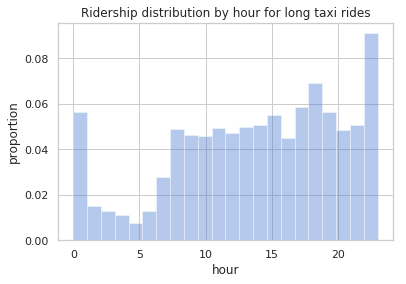

In [22]:
# Visualization 1
ax = sns.distplot(a = long_rides['hour'], kde = False, norm_hist = True)
plt.title('Ridership distribution by hour for long taxi rides')
plt.ylabel('proportion')

#### Visualization 2

Text(0,0.5,'proportion')

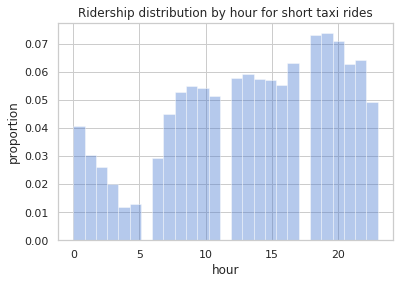

In [23]:
# Visualization 2
ax = sns.distplot(a = short_rides['hour'], kde = False, norm_hist = True)
plt.title('Ridership distribution by hour for short taxi rides')
plt.ylabel('proportion')

### Question 4b
Briefly explain for each plot
1. What feature you're visualization
2. Why you chose this feature
3. Why you chose this visualization method

In [24]:
q4b_answer = r"""

Visualization #1: 
Using the long_rides data set (rides of 15 minutes or longer), I chose to make a histogram of the distribution of rides by hour. In essence, we can see the hour by hour distribution of when New Yorkers were taking taxis. I chose this feature because I thought it would be interesting to see what the ridership patterns are during the workday, during both rush hours, during the evening/night-time hours when people are out for leisure, and during the late night hours when people are out partying or working the graveyard shift (which is very common in New York City). I chose to use a histogram because I was only plotting 1 variable.

Visualization #2: 
Using the short_rides data set (rides of 15 minutes or less), I chose to make a histogram of the distribution of rides by hour. In essence, we can see the hour by hour distribution of when New Yorkers were taking taxis. I chose this feature because I thought it would be interesting to see what the ridership patterns are during the workday, during both rush hours, during the evening/night-time hours when people are out for leisure, and during the late night hours when people are out partying or working the graveyard shift (which is very common in New York City). I chose to use a histogram because I was only plotting 1 variable.

In essence, I created these 2 plots to determine whether there was a significant difference in ridership behavior between long duration cabrides and short duration cabrides. 

"""

print(q4b_answer)



Visualization #1: 
Using the long_rides data set (rides of 15 minutes or longer), I chose to make a histogram of the distribution of rides by hour. In essence, we can see the hour by hour distribution of when New Yorkers were taking taxis. I chose this feature because I thought it would be interesting to see what the ridership patterns are during the workday, during both rush hours, during the evening/night-time hours when people are out for leisure, and during the late night hours when people are out partying or working the graveyard shift (which is very common in New York City). I chose to use a histogram because I was only plotting 1 variable.

Visualization #2: 
Using the short_rides data set (rides of 15 minutes or less), I chose to make a histogram of the distribution of rides by hour. In essence, we can see the hour by hour distribution of when New Yorkers were taking taxis. I chose this feature because I thought it would be interesting to see what the ridership patterns are d

### Question 4c

From the various plots above, what conclusions can you draw about the temporal aspects of our data? How does this relate to duration? 

In [25]:
q4c_answer = r"""

The first conclusion we can draw is that longer rides tend to be taken more at night than during the day, and especially moreso than during the early hours of the day (midnight to 5am) where there are hardly any long rides taken. This relates to duration, as long distance rides tend to be longer than short distance rides. 
The second conclusion we can draw is that short distance rides have a less clear pattern, as ridership during the workday, evening, and night hours are relatively similar. As with long distance rides, there is a signficant dropoff in short distance rides in the early hours of the day (midnight to 5am). This relates to duration, as short distance rides tend to be shorter in duration. 

Thus, longer duration rides tend to be taken more at night and evening than during the workday and morning. Shorter duration rides tend to be taken more during the workday, evening, and night hours. 

"""


print(q4c_answer)



The first conclusion we can draw is that longer rides tend to be taken more at night than during the day, and especially moreso than during the early hours of the day (midnight to 5am) where there are hardly any long rides taken. This relates to duration, as long distance rides tend to be longer than short distance rides. 
The second conclusion we can draw is that short distance rides have a less clear pattern, as ridership during the workday, evening, and night hours are relatively similar. As with long distance rides, there is a signficant dropoff in short distance rides in the early hours of the day (midnight to 5am). This relates to duration, as short distance rides tend to be shorter in duration. 

Thus, longer duration rides tend to be taken more at night and evening than during the workday and morning. Shorter duration rides tend to be taken more during the workday, evening, and night hours. 




### Question 4d

Previously, we have analyzed the temporal features `hour` and `day_of_week` independently, but these features may in fact have a relationship between each other. Determining the extent to their relationship may be useful in helping us create new features in our model. Create a violin plot that displays distribution of rides over each hour per day of the week.

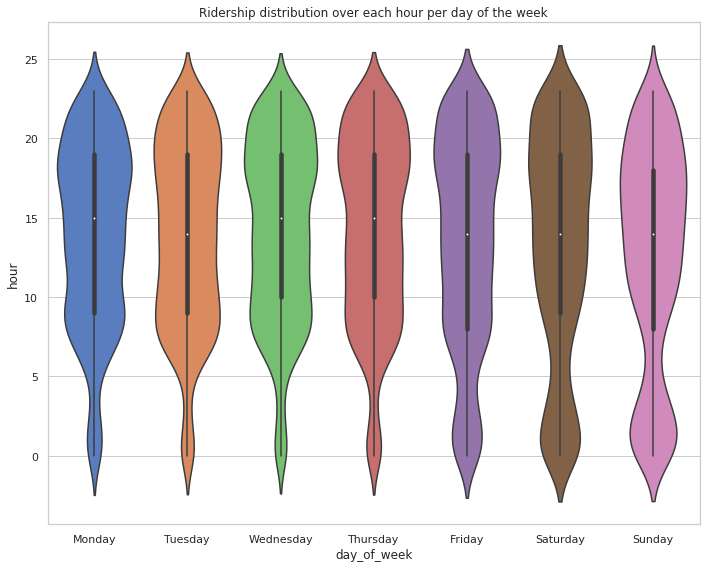

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

ax = sns.violinplot(x = "day_of_week", y = "hour", data = train_df)
ax.set_xticklabels(days_of_week)

plt.title('Ridership distribution over each hour per day of the week')

plt.tight_layout();

### Question 4e
Do you notice anything interesting about your visualization? How would you explain this plot to a lay person? What are the features/patterns of interest?

In [27]:
q4e_answer = r"""

An interesting pattern is that on Friday, Saturday, and Sunday, there are more rides taken between midnight and roughly 3am than on the 4 other days of the week. This is likely because these are associated with the days of the week where you would have fun. New Yorkers seem to confirm this idea, as they take more rides in the early hours of Friday, Saturday and Sunday nights than on other days of the week. 

Something else that's interesting is that the interquartile range for Monday, Tuesday, Wednesday, and Thursday is roughly the same between the hours of 9am and 6pm, corresponding to the hours of a typical workday. 

To a lay person, I would describe this plot as a ridership distribution of taxi rides taken hour by hour for each day of the week. Each bar on the graph is a frequency plot of taxi ridership with wider areas on each bar representing higher frequencies of ridership and smaller areas representing lower frequencies of ridership. The lines in between the bars represent the range of the data points, with the bold part of the line representing the range of rides between the 25th and 75th percentiles of rides by time of day taken. The white dots in the bold line represent the 50th percentile or the median time of day a taxi ride was taken in the dataset.

The features of this visualization are time (hour of the day) and the days of the week. Each violin plot has a kernel density estimator of ridership by time, interquartile range of rides, and the median ride for each day (by time). 

"""


print(q4e_answer)



An interesting pattern is that on Friday, Saturday, and Sunday, there are more rides taken between midnight and roughly 3am than on the 4 other days of the week. This is likely because these are associated with the days of the week where you would have fun. New Yorkers seem to confirm this idea, as they take more rides in the early hours of Friday, Saturday and Sunday nights than on other days of the week. 

Something else that's interesting is that the interquartile range for Monday, Tuesday, Wednesday, and Thursday is roughly the same between the hours of 9am and 6pm, corresponding to the hours of a typical workday. 

To a lay person, I would describe this plot as a ridership distribution of taxi rides taken hour by hour for each day of the week. Each bar on the graph is a frequency plot of taxi ridership with wider areas on each bar representing higher frequencies of ridership and smaller areas representing lower frequencies of ridership. The lines in between the bars represent th

## 5: Vendors

Recall that in Part 1, we found that there are only two unique vendors represented in the dataset. We may wonder if the vendor feature can be useful when trying to understand taxi ride duration.

### Question 5a
Visualize the VendorID feature. Create at least one plot that gives insight as to whether this feature would be useful or not in our model.

In [28]:
# Visualization for my curiosity, not the one I have written about. Output omitted.
#ax = sns.violinplot(x = "VendorID", y = "duration", data = train_df)
#plt.ylim(0, 10000)
#plt.title('Distribution of ride duration by Vendor ID')

Text(0,0.5,'duration (seconds)')

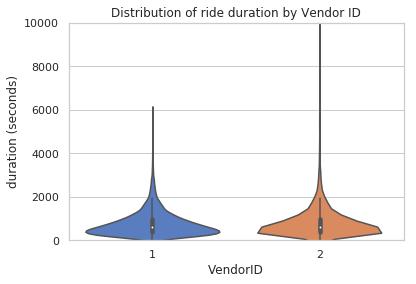

In [29]:
#Visualization I believe paints the clearest picture, and the one I have written about in question 5b.
ax = sns.violinplot(x = "VendorID", y = "duration", data = train_df)
plt.ylim(0, 10000)
plt.title('Distribution of ride duration by Vendor ID')
plt.ylabel('duration (seconds)')

In [30]:
#Visualization for my own curiosity, not very useful. I have not written about this. Output omitted.
#sns.distplot(a = train_df.loc[train_df['VendorID'] == 1, 'duration'], label = 'Vendor 1')
#sns.distplot(a = train_df.loc[train_df['VendorID'] == 2, 'duration'], label = 'Vendor 2')
#plt.title('Distribution of ride duration by Vendor ID')
#plt.ylabel('Proportion of Rides')

In [31]:
#Visualization for my own curiosity, not very useful. I have not written about this. Output omitted.
#sns.distplot(a = train_df.loc[train_df['VendorID'] == 1, 'duration'], label = 'Vendor 1')
#sns.distplot(a = train_df.loc[train_df['VendorID'] == 2, 'duration'], label = 'Vendor 2')
#plt.xlim(0, 10000)
#plt.title('Distribution of ride duration by Vendor ID')
#plt.ylabel('Proportion of Rides')

### Question 5b
Justify why you chose this visualization method and how it helps determine whether `vendor_id` is useful in our model or not.

In [32]:
q5b_answer = r"""

I chose this visualization method because it gives me both a kernel density estimator, interquartile range, and median of the distribution of rides for both vendors in the dataset. Side by side violin plots appeared to represent the data and summary statistics about it more clearly than other distributions we have learned about in this class. 

It helps determine whether vendor_id is useful in our model or not because we can compare the duration distributions side by side to see if there are any significant differences in interquartile range, median, or the distribution or if there are any interesting features (like the large range in vendor 2's duration distribution) that can be exploited to understand taxi ride duration more.  

"""

print(q5b_answer)



I chose this visualization method because it gives me both a kernel density estimator, interquartile range, and median of the distribution of rides for both vendors in the dataset. Side by side violin plots appeared to represent the data and summary statistics about it more clearly than other distributions we have learned about in this class. 

It helps determine whether vendor_id is useful in our model or not because we can compare the duration distributions side by side to see if there are any significant differences in interquartile range, median, or the distribution or if there are any interesting features (like the large range in vendor 2's duration distribution) that can be exploited to understand taxi ride duration more.  




### Question 5c
From the plot above, do you think vendor_id will help us understand duration? Why or why not?

In [33]:
q5c_answer = r"""

I think that vendor_id will not help us understand duration unless we are trying to classify extremely high duration rides (i.e. outliers in the data). The kernel density estimator, interquartile range, and median for both vendor's distributions are relatively similar. The only interesting feature that I could see being useful is the very large range of vendor 2's duration distribution with extremely high duration values present as outliers in vendor 2's dataset. Aside from this one interesting feature, there are no significant differences in duration between vendor 1's distribution and vendor 2's distribution, hence I don't think vendor_id will help us understand duration. 

"""


print(q5c_answer)



I think that vendor_id will not help us understand duration unless we are trying to classify extremely high duration rides (i.e. outliers in the data). The kernel density estimator, interquartile range, and median for both vendor's distributions are relatively similar. The only interesting feature that I could see being useful is the very large range of vendor 2's duration distribution with extremely high duration values present as outliers in vendor 2's dataset. Aside from this one interesting feature, there are no significant differences in duration between vendor 1's distribution and vendor 2's distribution, hence I don't think vendor_id will help us understand duration. 




## 6: Distance features

We can also use the coordinates information to compute distance features.  This will allow us to compute speed related features.  
We will compute the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) distance, the [manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance and the [bearing](http://www.mathsteacher.com.au/year7/ch08_angles/07_bear/bearing.htm) angle.

In [34]:
# These functions are implemented for you
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    
    The haversine formula determines the great-circle distance between two points 
    on a sphere given their longitudes and latitudes. Important in navigation, it 
    is a special case of a more general formula in spherical trigonometry, 
    the law of haversines, that relates the sides and angles of spherical triangles.
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Computes Manhattan distance
    
    The name alludes to the grid layout of most streets on the island of Manhattan, 
    which causes the shortest path a car could take between two intersections in the borough 
    to have length equal to the intersections' distance in taxicab geometry.
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [35]:
def add_distance_columns(df):
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    
    return df

In [36]:
train_df = add_distance_columns(train_df)
short_rides = add_distance_columns(short_rides)
long_rides = add_distance_columns(long_rides)

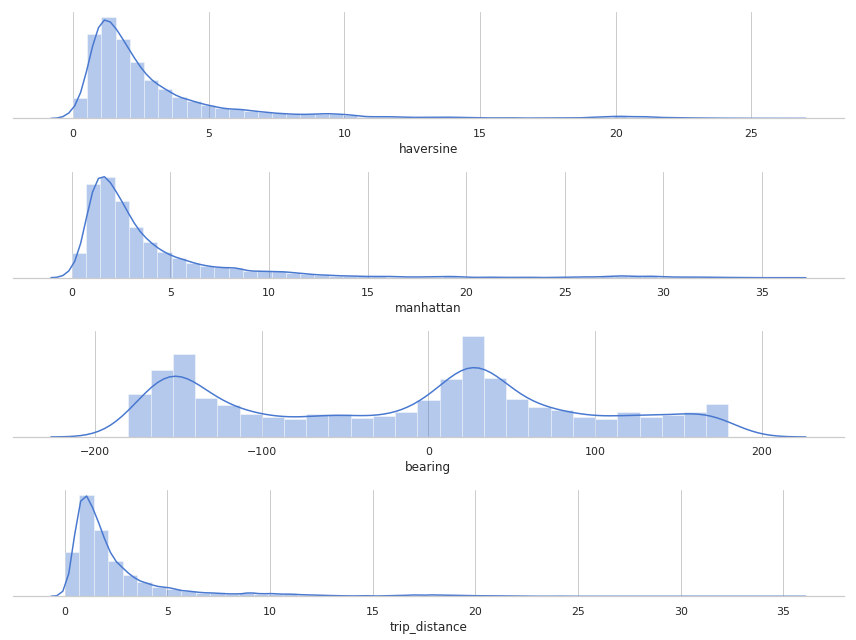

In [37]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9))
sns.distplot(train_df['haversine'], ax=axes[0], axlabel='haversine');
sns.distplot(train_df['manhattan'], ax=axes[1], axlabel='manhattan');
sns.distplot(train_df['bearing'], ax=axes[2], axlabel='bearing');
sns.distplot(train_df['trip_distance'], ax=axes[3], axlabel='trip_distance');

sns.despine(left=True);
plt.setp(axes, yticks=[]);
plt.tight_layout();


### Question 6a

The `bearing` direction is angle, the initial direction of the trip.  
The bearing direction has two prominent peaks around 30 and -150 degrees.  
**Can you relate these peaks to the orientation of Manhattan? What do you notice about these angles?**

**Hint:** This [wikipedia article](https://en.wikipedia.org/wiki/Commissioners%27_Plan_of_1811) has the answer, although it may take some digging. Alternatively, try to look at a map of Manhattan.

In [38]:
q6a_answer = r"""

On a compass, 30 degrees and -150 degrees correspond roughly to the directions north-northeast and south-southwest. Looking at a map of Manhattan, this appears to be the axis line and orientation that Manhattan lies on. In other words, if we laid Manhattan over a compass, its northern end would point toward 30 degrees and its southern end would point towards -150 degrees. Hence, this is why the distribution for bearing direction has 2 prominent peaks around 30 and -150 degrees. Taxi riders appear to be taking trips that start out initially directed towards the northern end or the southern end of Manhattan, which makes sense because Manhattan is a long and relatively narrow island and thus most rides are north/south rather than east/west. 

"""


print(q6a_answer)



On a compass, 30 degrees and -150 degrees correspond roughly to the directions north-northeast and south-southwest. Looking at a map of Manhattan, this appears to be the axis line and orientation that Manhattan lies on. In other words, if we laid Manhattan over a compass, its northern end would point toward 30 degrees and its southern end would point towards -150 degrees. Hence, this is why the distribution for bearing direction has 2 prominent peaks around 30 and -150 degrees. Taxi riders appear to be taking trips that start out initially directed towards the northern end or the southern end of Manhattan, which makes sense because Manhattan is a long and relatively narrow island and thus most rides are north/south rather than east/west. 




### Question 6b

For haversine and manhattan distances, it is probably more helpful to look at the log distribution. We are also curious about whether these distance features can help us understand duration. Create at least one plot that compares haversine and manhattan distances and gives insight as to whether this would be a useful feature in our model.

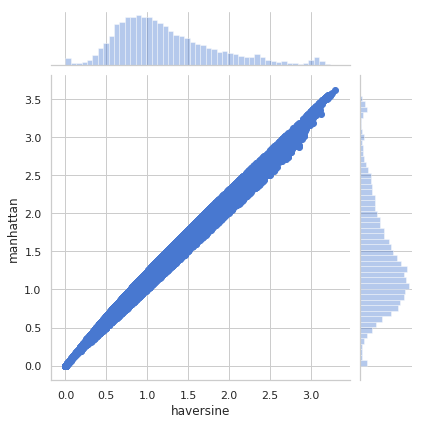

In [39]:
# Visualization
az = sns.jointplot(x = np.log(train_df['haversine'] + 1), y = np.log(train_df['manhattan'] + 1), data = train_df)

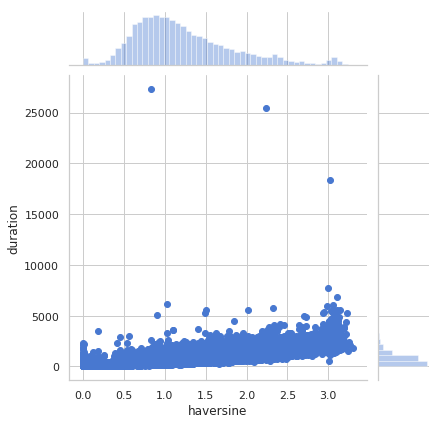

In [40]:
ax = sns.jointplot(x = np.log(train_df['haversine'] + 1), y = "duration", data = train_df)

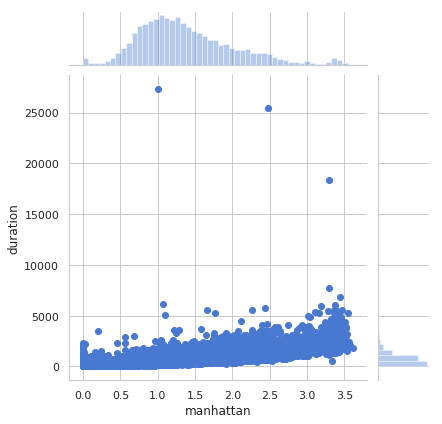

In [41]:
ay = sns.jointplot(x = np.log(train_df['manhattan'] + 1), y = "duration", data = train_df) 

### Question 6c
Justify why you chose this visualization method and how it helps inform you about using manhattan/haversine distance as a feature for predicting trip duration.

In [42]:
q6c_answer = r"""

I chose this visualization method because using sns's jointplot method allows me be plot 2 univariate distributions, in this case the log distributions of haversine and manhattan distances and the duration distribution in the dataset, on 1 plot against each other. Specifically, this is better than stacked histograms because we can more clearly see patterns between the 2 distributions than if we were looking at stacked histograms which may run together, making the individual distributions indiscernable. This helps inform me about what the nature of the relationship is between manhattan and haversine distances among New York taxi rides. 

The plot itself tells me the following things. First, the manhattan and haversine distances appear to have near perfect positive correlation. As the jointplot of their log distributions show, manhattan and haversine distances appear to be very similar in the taxi dataset, and as haversine distance increases, so does manhattan distance in a similar fashion. It appears that the line y=x would be a very good line of best fit, further supporting the idea that the two are nearly perfectly positively correlated. 

Second, there is a positive relationship between the log of manhattan distance and duration, and a positive relationship between the log of haversine distance and duration. This tells me that manhattan distance and haversine distance could be useful features for predicting trip duration, as there appears to be clear relationships between duration and the two variables. As manhattan distance and haversine distance increase, so does ride duration, which makes sense since the further you want to travel, the longer it should take. 

Third, the manhattan and haversine distances are computing nearly the same distances and durations. As the plots above show, manhattan and haversine distances are nearly identical, and they predict nearly identical durations as well. 

"""

print(q6c_answer)



I chose this visualization method because using sns's jointplot method allows me be plot 2 univariate distributions, in this case the log distributions of haversine and manhattan distances and the duration distribution in the dataset, on 1 plot against each other. Specifically, this is better than stacked histograms because we can more clearly see patterns between the 2 distributions than if we were looking at stacked histograms which may run together, making the individual distributions indiscernable. This helps inform me about what the nature of the relationship is between manhattan and haversine distances among New York taxi rides. 

The plot itself tells me the following things. First, the manhattan and haversine distances appear to have near perfect positive correlation. As the jointplot of their log distributions show, manhattan and haversine distances appear to be very similar in the taxi dataset, and as haversine distance increases, so does manhattan distance in a similar fas

### Question 6d
Fill in the code below to plot a scatter plot of manhattan distance vs duration.

Text(0.5,1,'A scatter plot of manhattan distance vs duration')

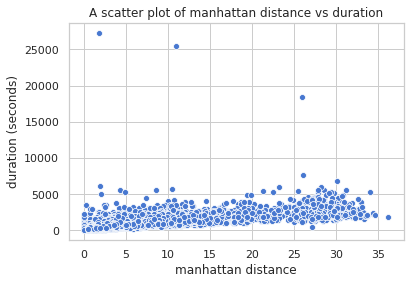

In [43]:
ax = sns.scatterplot(x = "manhattan", y = "duration", data = train_df)
plt.xlabel('manhattan distance')
plt.ylabel('duration (seconds)')
plt.title('A scatter plot of manhattan distance vs duration')

### Question 6e

According to the plot above, there are a few outliers in both duration and manhattan distance. **Which type of outliers is most likely to be a mistake in our data?**

In [44]:
q6e_answer = r"""

The type of outlier most likely to be a mistake in our data are datapoints that have low manhattan distances, but very high ride durations. If the shortest path between 2 intersections in the borough (definition of manhattan distance) is a low number, then it is illogical that such a ride would take longer than a ride with a higher manhattan distance. In other words, using the plot above, we can see that there are rides with higher manhattan distances, but lower durations than the outlier points (positions (3, 27,000), (11, 25,500), (26, 18,000)). These are the most likely errors in data entry in our dataset.

"""



print(q6e_answer)



The type of outlier most likely to be a mistake in our data are datapoints that have low manhattan distances, but very high ride durations. If the shortest path between 2 intersections in the borough (definition of manhattan distance) is a low number, then it is illogical that such a ride would take longer than a ride with a higher manhattan distance. In other words, using the plot above, we can see that there are rides with higher manhattan distances, but lower durations than the outlier points (positions (3, 27,000), (11, 25,500), (26, 18,000)). These are the most likely errors in data entry in our dataset.




## 7: Advanced features
You do not need to incorporate these features into your model, although it may help lower your error. You are required to read through this portion and respond to the questions. All of the code is provided, please skim through it and try to understand what each cell is doing.

### Clustering
[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is the task of grouping objects such that members within each group are more similar to each other than members of other groups. Clustering is a powerful tool used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics. Recall cluster sampling, which we learned earlier in the semester. We will use a simple clustering method (clustering by spatial locality) to reveal some more advanced features.

### Speed features

For `train_df`, we have the `duration` and now some distance information.  
This is enough for us to compute average speed and try to better understand our data.   

For `test_df`, we cannot use `duration` as a feature because it is what we are trying to predict. One clever way to include speed information for modeling would be as follows:

1. Cluster the observations in `train_df` by rounding the latitude and longitudes.
2. Compute the average speed per pickup cluster and dropoff cluster.
3. Match each observation in `test_df` to its pickup cluster and dropoff cluster based off the latitude and longitude, thus assigning the average speed for the pickup and dropoff cluster.
4. We have added speed information as features for `test_df`.

Therefore, we have propagated information computed in the `train_df` into the `test_df` via clustering. This is not something we will do in this notebook, although you can try it for yourself!

Other information that could be added based on clustering (both pickup cluster and dropoff cluster):
- Average of `avg_speed_h` per cluster.
- Average of `duration` per cluster.
- Average of `avg_speed_h` per cluster and hour.
- Average of `duration` per cluster and hour.
- In-cluster flow of trips for 60 min period.
- Out-cluster flow of trips for 60 min period.

In [45]:
# Calculate average manhattan speed
train_df['avg_speed_m'] = 1000 * train_df['manhattan'] / train_df['duration']
train_df['avg_speed_m'] = train_df['avg_speed_m'][train_df['avg_speed_m'] < 100]
train_df['avg_speed_m'].fillna(train_df['avg_speed_m'].median(), inplace=True)

In [46]:
train_df['avg_speed_m'].describe()

count    18354.000000
mean         5.210825
std          2.883174
min          0.000000
25%          3.287328
50%          4.617264
75%          6.413992
max         59.225577
Name: avg_speed_m, dtype: float64

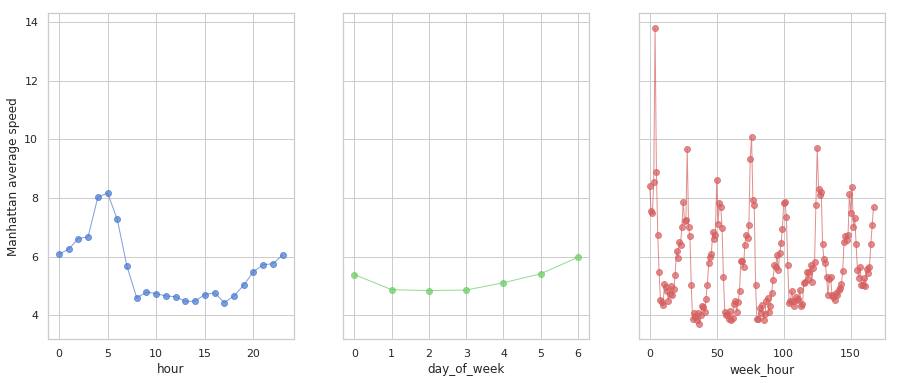

In [47]:
# Visualize average manhattan speed by hour, day of week and week hour
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)

axes[0].plot(train_df.groupby('hour').mean()['avg_speed_m'], 'bo-', lw=1, alpha=0.7)
axes[1].plot(train_df.groupby('day_of_week').mean()['avg_speed_m'], 'go-', lw=1, alpha=0.7)
axes[2].plot(train_df.groupby('week_hour').mean()['avg_speed_m'], 'ro-', lw=1, alpha=0.7)

axes[0].set_xlabel('hour')
axes[1].set_xlabel('day_of_week')
axes[2].set_xlabel('week_hour')
axes[0].set_ylabel('Manhattan average speed');

### Question 7a
Based off of these visualizations, provide 2-3 insights on the average speed.

In [48]:
q7a_answer = r"""

On the plot of hour vs average speed, there appears to be higher speeds on roads between midnight and 5am, when very few people are on the road except delivery trucks. From 5 to 8am, average speed declines as more people get on the roads to commute to their work during rush hour. Then from 8am to 5pm, average speeds stay roughly the same as taxi drivers, delivery trucks, police cars, fire trucks, and other vehicles move around during the business day to do their work, providing a steady volume of high traffic, keeping average speeds low in Manhattan. After 5pm, average speeds steadily increase as more people go home or get off the roads, making Manhattan less congested and allowing for faster road travel. Slower speeds are correlated during both rush hours and the traditional workday, and higher speeds are associated with non-work hours (after work or when people usually sleep).

On the plot of day of week vs average speed, it appears that average speeds are roughly the same for Monday through Saturday, with a noticeably higher average speed on Sunday. After Thursday, average speeds increase from Friday through the weekend, as people generally enjoy more leisure time and spend less of their days at work. There are also less people coming into Manhattan from other areas on Friday, Saturday and Sunday, as work commuters tend to drive cars into Manhattan if they live outside New York City. Less people commute or have to drive to workplaces, so there are less cars on the road, and higher average speeds. It is highest on Sunday because that tends to be the day where people do the least work and spend the most time doing leisurely activities in their homes, the outdoors, or in common spaces. Hence, there are less cars on the roads and less people coming into Manhattan for work, and thus higher average speeds.

On the plot of week_hour vs average speed, it appears that the same trends from the other 2 graphs hold. The only interesting new pattern we can see is that the peaks of average speed appear to decrease as the week progresses. The highest peak is in the early hours of Monday morning right after Sunday night, which is when usually people go out the least (hence the roads are the least crowded). The lowest early hour peaks are on Friday, Saturday, and Sunday, when people go out the most. The lowest troughs are early in the week, as more people are driving around for work or commuting earlier in the week than later in the week.
"""



print(q7a_answer)



On the plot of hour vs average speed, there appears to be higher speeds on roads between midnight and 5am, when very few people are on the road except delivery trucks. From 5 to 8am, average speed declines as more people get on the roads to commute to their work during rush hour. Then from 8am to 5pm, average speeds stay roughly the same as taxi drivers, delivery trucks, police cars, fire trucks, and other vehicles move around during the business day to do their work, providing a steady volume of high traffic, keeping average speeds low in Manhattan. After 5pm, average speeds steadily increase as more people go home or get off the roads, making Manhattan less congested and allowing for faster road travel. Slower speeds are correlated during both rush hours and the traditional workday, and higher speeds are associated with non-work hours (after work or when people usually sleep).

On the plot of day of week vs average speed, it appears that average speeds are roughly the same for Mond

We are now going to visualize the average speed per region. Here we define regions as a very basic classical clustering based on rounding of spatial coordinates.

In [49]:
# Round / bin the latitude and longitudes
train_df['start_lat_bin'] = np.round(train_df['pickup_latitude'], 3)
train_df['start_lng_bin'] = np.round(train_df['pickup_longitude'], 3)

# Average speed for regions
gby_cols = ['start_lat_bin', 'start_lng_bin']

coord_stats = (train_df.groupby(gby_cols)
               .agg({'avg_speed_m': 'mean', 'manhattan': 'count'})
               .reset_index())

coord_stats = coord_stats[coord_stats['manhattan'] > 10]

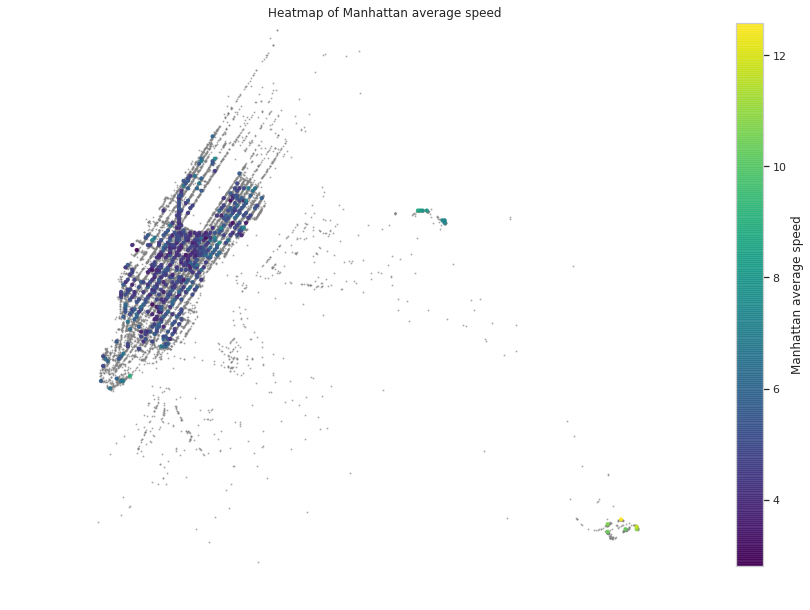

In [50]:
# Visualize the average speed per region
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(train_df['pickup_longitude'].values,
                           train_df['pickup_latitude'].values,
                           color='grey', s=1, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['start_lng_bin'].values,
                          coord_stats['start_lat_bin'].values,
                          c=coord_stats['avg_speed_m'].values,
                          cmap='viridis', s=10, alpha=0.9)

cbar = fig.colorbar(scatter_cmap)
cbar.set_label("Manhattan average speed")
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heatmap of Manhattan average speed')
plt.axis('off');

### Question 7b
In 2-3 sentences, describe how we can use the clustering visualization above to gain insight on the speed. Do you think spatial clustering would be useful in reducing the error of our model?

In [51]:
q7b_answer = r"""

We can use the visualization to determine what areas of the city experience higher average speeds in the dataset and compare average speeds by borough in the dataset. It's clear that rides in Lower and Midtown Manhattan are slower compared to rides outside of Manhattan, but further conclusions outside of that are unclear due to the overplotting present in the graph. Spatial clustering could be useful in reducing the error of the model, since they would allow us to group New York City into different clusters, and then analyze average speed distributions within each cluster, thus reducing the error in our model by providing more precise estimators of average speed in New York City. 

"""



print(q7b_answer)



We can use the visualization to determine what areas of the city experience higher average speeds in the dataset and compare average speeds by borough in the dataset. It's clear that rides in Lower and Midtown Manhattan are slower compared to rides outside of Manhattan, but further conclusions outside of that are unclear due to the overplotting present in the graph. Spatial clustering could be useful in reducing the error of the model, since they would allow us to group New York City into different clusters, and then analyze average speed distributions within each cluster, thus reducing the error in our model by providing more precise estimators of average speed in New York City. 




## Part 2 Exports
We are not requiring you to export anything from this notebook, but you may find it useful to do so. There is a space below for you to export anything you wish.

In [52]:
Path("data/part2").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part2", "data_part2.hdf") # Path of hdf file
...

Ellipsis

## Part 2 Conclusions 

We now have a good understanding of the taxi data we are working with.
Visualizing large amounts of data can be a difficult task. One helpful tool is [datashader](https://github.com/bokeh/datashader), a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data. Using the [geopandas](http://geopandas.org/) package also makes working with geospatial data easier. We encourage you to explore these tools if you are interested in learning more about visualization!

Within our taxi data set, we have explored different features and their relationship with ride duration. Now, we are ready to incorporate more data in order to add to our set of features.

**Please proceed to part 3 where we will be engineering more features and building our models using a processing pipeline.**

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**